In [25]:
dc_coef = None

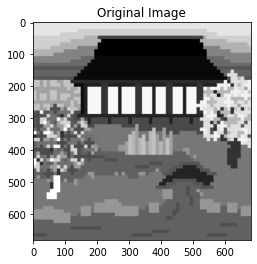

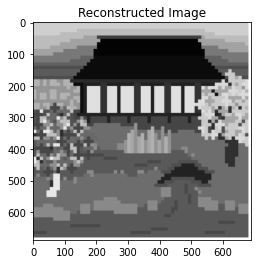

(680, 680, 3)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 412, 375, 303, 0, 0, 0, 0, 233, 11, 0, 0, 141, 5, 0, 0, 0, 0, 0, 0, 870, -870, 0, 0, 0]
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 612, 987, 1290, 1290, 1290, 1290, 1290, 1523, 1534, 1534, 1534, 1675, 1680, 1680, 1680, 1680, 1680, 1680, 1680, 2550, 1680, 1680, 1680, 1680]
7395
Indices where old_enc and new_enc differ: [   1    2    3 ... 7393 7394 7395]


In [26]:
import cv2
import numpy as np
import math
import heapq
from collections import Counter
import matplotlib.pyplot as plt

old_quant = None
old_enc = None
new_enc = None
new_quant = None
class HuffmanNode:
    """Class for a node in the Huffman tree."""
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq


class JPEGCodec:
    """Class to perform JPEG compression and decompression."""
    def __init__(self):
        self.Q_50_matrix = np.array([
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 25, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]
        ], dtype=float)
        self.zigzag_order = [
            0,  1,  5,  6, 14, 15, 27, 28,
            2,  4,  7, 13, 16, 26, 29, 42,
            3,  8, 12, 17, 25, 30, 41, 43,
            9, 11, 18, 24, 31, 40, 44, 53,
           10, 19, 23, 32, 39, 45, 52, 54,
           20, 22, 33, 38, 46, 51, 55, 60,
           21, 34, 37, 47, 50, 56, 59, 61,
           35, 36, 48, 49, 57, 58, 62, 63,
        ]

    @staticmethod
    def compute_size(value):
        """Compute the size of a value."""
        if value == 0:
            return 0
        return int(np.floor(np.log2(abs(value))) + 1)

    def zigzag_flatten(self, block):
        """Flatten an 8x8 block in zigzag order."""
        flat = block.flatten()
        return [flat[idx] for idx in self.zigzag_order]


    @staticmethod
    def build_huffman_tree(frequencies):
        """Build a Huffman tree from frequency data."""
        heap = [HuffmanNode(symbol, freq) for symbol, freq in frequencies.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            node1 = heapq.heappop(heap)
            node2 = heapq.heappop(heap)
            merged = HuffmanNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            heapq.heappush(heap, merged)
        return heap[0]

    @staticmethod
    def generate_huffman_codes(node, code="", codebook=None):
        """Generate Huffman codes from a Huffman tree."""
        if codebook is None:
            codebook = {}  # Initialize a new dictionary if none is provided

        if node is not None:
            if node.symbol is not None:  # Leaf node
                codebook[node.symbol] = code
            JPEGCodec.generate_huffman_codes(node.left, code + "0", codebook)
            JPEGCodec.generate_huffman_codes(node.right, code + "1", codebook)

        return codebook

    @staticmethod
    def build_huffman_decoding_map(codes):
        """Build a decoding map from Huffman codes."""
        return {code: symbol for symbol, code in codes.items()}

    def to_grayscale(self, image):
        """
        Convert the input image to grayscale.
        If the image is already single-channel, return it as-is.
        """
        if len(image.shape) == 3:  # Color image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return image

    def pad_image(self, image):
        """
        Pad the grayscale image to make its dimensions a multiple of 8.
        """
        padded_height = (image.shape[0] // 8 + 1) * 8
        padded_width = (image.shape[1] // 8 + 1) * 8
        padded_image = np.full((padded_height, padded_width), 255, dtype=image.dtype)  # Default pad with 255
        padded_image[:image.shape[0], :image.shape[1]] = image
        return padded_image

    def quantize_image(self, padded_image, quality=50):
        """
        Divide the image into 8x8 blocks, apply DCT, and quantize the coefficients.
        """
        quantized_matrix = np.zeros_like(padded_image, dtype=int)
        height, width = padded_image.shape

        q_matrix = (50 / quality) * self.Q_50_matrix  # Adjust quantization matrix based on quality

        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = padded_image[i:i+8, j:j+8]
                dct_block = cv2.dct(block.astype(float))
                quantized_matrix[i:i+8, j:j+8] = np.round(dct_block / q_matrix)
        return quantized_matrix


    def jpeg_huffman_encode(self, quantized_matrix):
        """Perform Huffman encoding on quantized coefficients."""
        height, width = quantized_matrix.shape
        dc_differences = []
        ac_symbols = []

        previous_dc = 0
        flat_blocks = []
        global old_enc
        old_enc = []

        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = quantized_matrix[i:i+8, j:j+8]
                flat = self.zigzag_flatten(block)
                flat_blocks.append(flat)

                # DC coefficient
                dc = flat[0]
                dc_diff = dc - previous_dc
                dc_differences.append(dc_diff)
                old_enc.append(dc_diff)
                previous_dc = dc

                # AC coefficients
                run_length = 0
                last_non_zero = -1
                for coef in range(len(flat)-1, 0, -1):
                    if(flat[coef]!=0):
                        last_non_zero = coef
                        break
                if(last_non_zero==-1):
                    ac_symbols.append((0, 0))
                else: 
                    for coef in flat[1:last_non_zero+1]:
                        if coef == 0:
                            run_length += 1
                            if run_length == 16:  # Max run-length encoding
                                ac_symbols.append((15, 0, 0))
                                run_length = 0
                        else:
                            ac_symbols.append((run_length, 0, coef))
                            run_length = 0
                    if last_non_zero != 63:
                        ac_symbols.append((0, 0))  # End of block
        self.temp = dc_differences 
        # Create frequency tables
        dc_frequencies = Counter(dc_differences)
        ac_frequencies = Counter([val[2] if len(val)==3 else val[1] for val in ac_symbols ])
        
        # Build Huffman trees
        dc_tree = self.build_huffman_tree(dc_frequencies)
        ac_tree = self.build_huffman_tree(ac_frequencies)

        # Generate Huffman codes
        dc_codes = self.generate_huffman_codes(dc_tree)
        ac_codes = self.generate_huffman_codes(ac_tree)

        # Encode data
        encoded_dc = [dc_codes[diff] for diff in dc_differences]
        encoded_ac = [(symbol[0], symbol[1], ac_codes[symbol[2]]) if len(symbol)==3 else (symbol[0], ac_codes[symbol[1]]) for symbol in ac_symbols]
        return dc_codes, ac_codes, encoded_dc, encoded_ac

    # Reverse zigzag to reconstruct 8x8 blocks
    def reverse_zigzag(self, flattened_block):
        """Reconstruct an 8x8 block from a zigzag flattened block."""
        block = np.zeros(64, dtype=int)
        for i, idx in enumerate(self.zigzag_order):
            block[idx] = flattened_block[i]
        return block.reshape(8, 8)

    # Build a Huffman decoding map from the codes
    def build_huffman_decoding_map(self, codes):
        decoding_map = {}
        for symbol, code in codes.items():
            decoding_map[code] = symbol
        return decoding_map

    # Decode Huffman-encoded data using the decoding map
    def decode_huffman_data(self, encoded_data, decoding_map):
        current_code = ""
        decoded_symbols = []
        for element in encoded_data:
            current_code += str(element)
            if current_code in decoding_map:
                decoded_symbols.append(decoding_map[current_code])
                current_code = ""
        if(current_code != ""):
            raise ValueError("Encoded bit not present in map")
        return decoded_symbols

    # Decode DC coefficients
    def decode_dc_coefficients(self, encoded_dc, dc_decoding_map):
        dc_differences = self.temp #self.decode_huffman_data(encoded_dc, dc_decoding_map)
        # min_index = 2170
        # max_index = 2170
        # print(dc_differences[2170:2180])
        # print(encoded_dc[2170:2180])
        #encoded_dc = "".join([str(el) for el in encoded_dc])
        dc_differences = self.decode_huffman_data(encoded_dc, dc_decoding_map)### Uncomment this for actual result
        # unequal_elements = [(i, self.temp[i], dc_differences[i]) for i in range(len(self.temp)) if self.temp[i] != dc_differences[i]]
        # print("Unequal elements (index, self.temp, dc_differences):", unequal_elements)
        # print(dc_differences[2170:2180])
        # input()
        dc_coefficients = []
        global new_enc
        new_enc = []
        previous_dc = 0
        # print(dc_differences[900:950])
        count = 0
        for diff in dc_differences:
            current_dc = previous_dc + diff
            if(count<100):
                count+=1
            dc_coefficients.append(current_dc)
            previous_dc = current_dc
            new_enc.append(current_dc)
        # print(dc_coefficients[900:950])
        return dc_coefficients

    # Decode AC coefficients
    def decode_ac_coefficients(self, encoded_ac, ac_decoding_map):
        encoded_ac_values = [symbol[-1] for symbol in encoded_ac]
        ac_values_symbols = self.decode_huffman_data(encoded_ac_values, ac_decoding_map)
        ac_symbols = [(encoded_ac[i][0], encoded_ac[i][1], ac_values_symbols[i]) if len(encoded_ac[i])==3 else (encoded_ac[i][0], ac_values_symbols[i]) for i in range(len(ac_values_symbols))]
        ac_coefficients = []
        count_of_block = 0
        for symbol in ac_symbols:
            if (symbol == (0, 0)):  # End-of-block (EOB)
                while count_of_block < 63:
                    ac_coefficients.append(0)
                    count_of_block+=1
                count_of_block = 0
            else:
                run_length, size, value = symbol
                ac_coefficients.extend([0] * run_length)
                ac_coefficients.append(value)
                count_of_block+= (1+run_length)

                if(count_of_block==63):
                    count_of_block = 0
        return ac_coefficients

    # Reconstruct the quantized coefficients matrix
    def reconstruct_quantized_matrix(self, dc_coefficients, ac_coefficients, height, width):
        matrix = np.zeros((height, width), dtype=int)
        block_index = 0
        ac_index = 0
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                # Initialize block with zeros
                block = np.zeros(64, dtype=int)

                # Set DC coefficient
                block[0] = dc_coefficients[block_index]

                # Set AC coefficients
                for k in range(1, 64):
                    block[k] = ac_coefficients[ac_index]
                    ac_index += 1

                # Reverse zigzag to reconstruct the block
                block_2d = self.reverse_zigzag(block)
                matrix[i:i+8, j:j+8] = block_2d

                block_index += 1

        return matrix

    # Main function to decode the Huffman-encoded data
    def jpeg_huffman_decode(self, dc_codes, ac_codes, encoded_dc, encoded_ac, height, width):
        # Build Huffman decoding maps
        dc_decoding_map = self.build_huffman_decoding_map(dc_codes)
        ac_decoding_map = self.build_huffman_decoding_map(ac_codes)

        # Decode DC coefficients
        dc_coefficients = self.decode_dc_coefficients(encoded_dc, dc_decoding_map)

        # Decode AC coefficients
        ac_coefficients = self.decode_ac_coefficients(encoded_ac, ac_decoding_map)

        # Reconstruct quantized coefficients matrix
        quantized_matrix = self.reconstruct_quantized_matrix(dc_coefficients, ac_coefficients, height, width)

        return quantized_matrix
    
    def reconstruct_image(self, reconstructed_matrix, quality):
        """
        Reconstruct an image from its quantized DCT coefficients.
        
        Args:
            reconstructed_matrix (ndarray): Quantized DCT coefficients matrix.
            q_matrix (ndarray): Quantization matrix used during encoding.

        Returns:
            ndarray: Reconstructed image.
        """
        height, width = reconstructed_matrix.shape
        reconstructed_image = np.zeros((height, width))

        q_matrix = (50 / quality) * self.Q_50_matrix  # Adjust quantization matrix based on quality
        global new_quant
        new_quant = np.zeros((height, width))
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = reconstructed_matrix[i:i+8, j:j+8]
                iquan_coef = np.zeros((8, 8))
                
                # Dequantize the block
                for m in range(8):
                    for n in range(8):
                        iquan_coef[m, n] = block[m, n] * q_matrix[m, n]
                new_quant[i:i+8, j:j+8] = iquan_coef
                # Apply inverse DCT to the block
                reconstructed_image[i:i+8, j:j+8] = cv2.idct(iquan_coef)

        return reconstructed_image
    
    def encode_to_bits(self, dc_codes, ac_codes, encoded_dc, encoded_ac, height, width):
        return [dc_codes, ac_codes, encoded_dc, encoded_ac, height, width]

    def decode_from_bits(self, bits):
        return bits[0], bits[1], bits[2], bits[3], bits[4], bits[5]

    def encode(self, image, quality = 50):
        """Perform full JPEG encoding."""
        grayscale = self.to_grayscale(image)
        padded = self.pad_image(grayscale)
        quantized = self.quantize_image(padded, quality)
        global old_quant
        old_quant = quantized
        dc_codes, ac_codes, encoded_dc, encoded_ac = self.jpeg_huffman_encode(quantized)
        height, width = np.shape(quantized)
        encoded_bits =self.encode_to_bits(dc_codes, ac_codes, encoded_dc, encoded_ac, height, width)
        return encoded_bits


    def decode(self, encoded_data, quality = 50):
        """Perform full JPEG decoding."""
        dc_codes, ac_codes, encoded_dc, encoded_ac, height, width = self.decode_from_bits(encoded_data)
        reconstructed_matrix = self.jpeg_huffman_decode(dc_codes, ac_codes, encoded_dc, encoded_ac, height, width)
        reconstructed_image = self.reconstruct_image(reconstructed_matrix, quality)
        return reconstructed_image
    

test_images = ["flower.png", "tower.png", "house.png"]
Q = 1000
codec = JPEGCodec()
image = cv2.imread('images\\' + test_images[2])
bits = codec.encode(image, Q)
reconstructed_image = codec.decode(bits, Q)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.title("Original Image")
plt.show()

plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.show()

print(image.shape)
print(old_enc[900:950])
print(new_enc[900:950])
print(sum((np.array(old_enc)-np.array(new_enc)) != 0))

# Find indices where old_enc and new_enc are not equal
diff_indices = np.where(np.array(old_enc) != np.array(new_enc))[0]
print("Indices where old_enc and new_enc differ:", diff_indices)






In [27]:
dc_frequencies = Counter(old_enc)
dc_tree = codec.build_huffman_tree(dc_frequencies)
dc_codes = codec.generate_huffman_codes(dc_tree)
encoded_dc = [dc_codes[diff] for diff in old_enc]
dc_decoding_map = codec.build_huffman_decoding_map(dc_codes)
decoded_dc = codec.decode_huffman_data(encoded_dc, dc_decoding_map)
for i in range(100):
    print(decoded_dc[i], old_enc[i])
unequal_elements = [(i, decoded_dc[i], old_enc[i]) for i in range(len(decoded_dc)) if decoded_dc[i] != old_enc[i]]
print("Unequal elements (index, decoded_dc, old_enc):", unequal_elements)

2100 2100
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
450 450
-450 -450
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
Unequal elements (index, decoded_dc, old_enc): []


In [28]:
dc_codes[452], dc_codes[-111]

KeyError: 452